/Users/parthparakh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.
         Current function value: -942.410247
         Iterations: 299
         Function evaluations: 589
[1.18005075e+02 3.70958489e-01 8.45259475e-03]


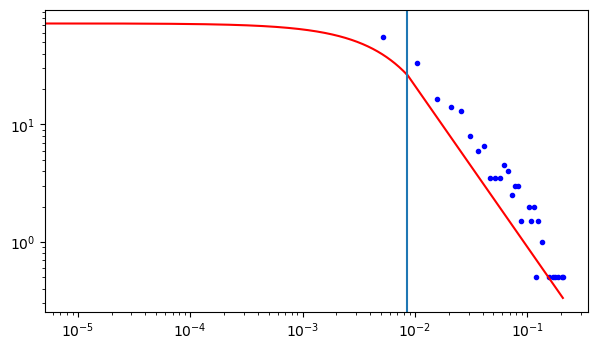

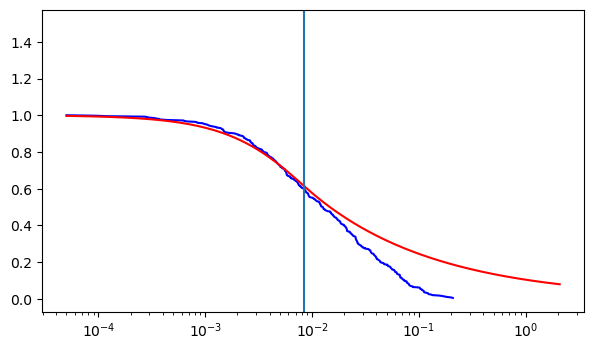

In [49]:
#!/usr/bin/python3.7
#Case_Study1-fitting.py
#Parth Parakh
#purpose: Maximum Likelihood on Crypocurrency Data
#---------------------------------------------------------------------
#import modules
import numpy as np
import csv
import scipy.optimize
import matplotlib.pyplot as plt
#----------------------------------------------------------------------
#helper function
def readFile(fileName):
    with open(fileName) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)
    return d

def tail_body_likelihood(params,r,pen) : 

    l = params[0]; alpha = params[1]; xmin = params[2];
    #print(params)
    C = 2-np.exp(-l*xmin); # Normalization constant
    
    L = 0; # Initializing likelihood
   
    # Finding returns lower than xmin
    r = np.sort(r,axis = 0);
    
    s = [];
    for i in r:
        if(i<xmin):
            s = np.append(s,i);
            
    f = len(s)
    
    # Computing log-likelihood values for the body of the distribution 
    for i in range(1,f):
        L = L-np.log(C)+np.log(l)-l*r[i];
    
    # Computing log-likelihood values for the tail of the distribution     
    for i in range(f+1,len(r)):
        L = L-np.log(C)+np.log(alpha/xmin)-(alpha+1)*np.log(r[i]/xmin);
    
    # Computing values of body and tail distributions at xmin
    Fbody = l*np.exp(-l*xmin)/C;
    Ftail = alpha/(C*xmin);
    
    # Adding penalty term to enforce continuity
    L = L - pen*(Fbody-Ftail)**2;
    
    # Changing sign to log-likelihood (fminsearch algorithm searches for minima)
    L = - L;
    
    return L;

if __name__ == '__main__':
    file = readFile("cryptocurrency_prices.txt")
    data = (file)
    b = data[0]
    
    r = np.zeros((len(b)-1,1))
    for i in range(0,len(b)-1):
        den = float(b[i])
        num = float(b[i+1]);
        r[i] = np.log(num/den);
        
    s = []
    for i in r:
        if(i<0):
            s = np.append(s,i);
    
    r = np.abs(s);
    
    
    penalty = 10; #Penalty parameter (to enforce continuity in xmin)

    ### Initial values of the distribution's parameter to be passed as input to
    ### the ML optimization problem
    lambdaa = 10; alpha = 2; xmin = 0.05; 
    params = [lambdaa,alpha,xmin]

    par = scipy.optimize.fmin(tail_body_likelihood,x0=params,args=(r,penalty,),maxiter=1000,maxfun=5000,xtol=1e-12) 
    
    print(par)
    
    lambdaa = par[0]; alpha = par[1]; xmin = par[2];
    
    # Plotting empirical vs calibrated distribution ##########
    
    C = 2 - np.exp(-lambdaa*xmin);
    
    NB = 40;
    
    plot1 = plt.figure(1,figsize=(7,4), dpi=100)
    a,b = np.histogram(r,NB,density=True);
    plt.loglog(b[1:],a,'b.');
    x = np.linspace(0,xmin,1000);
    plt.loglog(x,lambdaa*np.exp(-lambdaa*x)/C,'-r')
    x = np.linspace(xmin,max(r),1000);
    plt.loglog(x,alpha*(x/xmin)**(-alpha-1)/(C*xmin),'-r')
    plt.axvline(xmin)
    plt.xlim =(min(r),max(r));
    
    plot1 = plt.figure(2,figsize=(7,4), dpi=100)
    r = np.sort(r,axis=None); # Returns sorted in ascending order
    y = np.arange(0,len(r),1); 
    y = 1-y/(len(r)+1); # Calculating CCDF as rank-frequency plot
    plt.plot(r,y,'b','LineWidth',1.5)
    x = np.linspace(np.min(r),xmin,1000);
    plt.plot(x,1-(1-np.exp(-lambdaa*x))/C,'-r','LineWidth',1.5)
    x = np.linspace(xmin,max(r)*10,1000);
    plt.plot(x,1-(1-np.exp(-lambdaa*xmin)+1-(xmin/x)**alpha)/C,'-r','LineWidth',1.5)
    plt.axvline(xmin);
    plt.xscale('log');
    plt.xlim = ([np.min(r),np.max(r)]);
    plt.ylim = ([0,1]);